# Training a CNN with Pytorch
We will now be using a expanded version of the digits data set to train a convolutional neural network.

We will be using the Pytorch library, which is one of the main deep learning libraries. In comparison to SKlearn, Pytorch provides much more control over the architecture of your neural network, allowing you to create your own types of layers.

## Import libraries, including PyTorch
If you are using your own computer, you will need to install Pytorch. Setup guidance is here: https://pytorch.org/get-started/locally/)

In [1]:
import torch as torch
torch.set_num_threads(2)
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd

The next lines check if your computer has CUDA GPU capabilities and uses it if it can. Elab doesn't have available GPUs, this means that the model will still train, but it will be slower. More explanation below on what speeds you should be expecting.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Import some data
PyTorch has some built in datasets, which we will be using. We will be using the MNIST digits data set, which is a larger version of the sklearn digits dataset

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
    )
    
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
    )

## View basic data set information
Now that the dataset has been imported, you can view information about the train/test set using print(train_data) if you wish. You will see that there are 60000 training examples and 10000 test examples

In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Like the Sklearn task, let's plot one of the images to see what we're looking at. Note that these are grayscale images (i.e. different shades of grey) rather than full RGB colour images. The assignment data set will contain colour images.

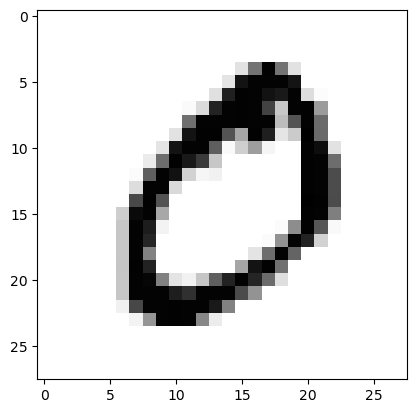

In [5]:
plt.imshow(train_data.data[1], cmap='Greys')
plt.show()

In [6]:
train_data.data[1].size()


torch.Size([28, 28])

# Create the neural network architecture as a new class, CNN

Defining a 'class' is beyond the scope of the course here - for a thorough introduction, read some material on Object Oriented Programming. Briefly, we can think of a 'class' as a grouping for a set of related variables and functions.

The CNN class below creates the neural network architecture. Note that nn.sequential means that layers are added sequentially, so conv1 consists of a conv2d layer, a ReLU activation and a max pooling layer. Each layer type has its own parameters (in_channels, out_channels, etc.)

In conv1, the convolution (conv2d) layer, we create 16 convolution filters (out_channels), a free choice by us (it can be any number). 

In the 2nd set of convolutions, defined by *conv2*, we have 16 convolutions from *conv1*, so our first parameter is 16 and we choose to have 32 output filters. Note that, for *conv2*, the parameters have been written in shorthand, without explicitly referring to the parameter variable name.

The function, forward, describes how the whole network is put together from its component layers. It shows how we first put our input through *conv1*, then *conv2*, then *out* (a fully connected layer). 

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        #self.out = nn.Linear(32 * 7 * 7, 10)
        self.out = nn.Linear(64 * 3 * 3, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

## Instantiate the neural network object
The class code above describes what our CNN object looks like, but we need to actual create an instance of the object. We do a similar thing when we train models in sklearn

In [8]:
cnn = CNN() # note that the variable name can be anything here, but I've chosen cnn for clarity

# Define the loss function and optimizer 
We now define the loss function and optimizer to train the network. Unlike standard stochastic gradient descent (what we looked at in the lectures), Adam is a variant that uses an adaptive learning rate to allow for faster convergence in many situations.

We set the initial learning rate at 0.01. This is quite large and may lead to non-convergence in other problems, but in this case I know it works (through trial and error), and it means that we will be able to see the impact of training in relatively few iterations

We use the cross entropy loss, which is the go-to for classification problems, rather than something like the mean squared error.

In [9]:
loss_func = nn.CrossEntropyLoss()   
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

# Set up training parameters

Before attempting to train, we use the dataloader utility in pytorch to set up how training will work: 
the *batch_size* sets the mini-batch used in SGD (i.e. how many examples are considered at each step - in the lectures, we consider one example at a time, so-called online SGD). *shuffle* shuffles the data at each epoch, to reduce the likelihood of a weird convergence. This might happen, for instance, if all of the digits are in order, so that all of the 1s are trained first. This could lead to a situation where the network thinks that it has finished training because it sees thousands of examples of 1s, and only trains to recognise 1s. *num_workers* relates to how the data is handled in the memory (e.g. whether there are multiple sub-processes)

In [21]:
from torch.utils.data import DataLoader
loaders = {
    'train' : DataLoader(train_data, 
                                          batch_size=200, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

## Training function
We now define how model training works, over num_epochs. Note how the loss is computed. Gradients are computed using loss.backward, and then weights are updated using optimizer.step()

In [22]:
num_epochs = 3
def train(num_epochs, cnn, loaders):
    
    # this sets the model mode - (i.e. layers like dropout, batchnorm etc behave differently during training compared to testing)
    # note that this function was not defined explicitly in CNN, but because CNN is a type of nn.Module, it inherits some functions
    # from the more general nn class.
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
       
            b_x = images
            b_y = labels
            
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass     
        pass
    pass

After you have run everything above, call the training function below.

**if you are running this on elab, note that it will take a *long* time to run. You may get faster results by running this on a local machine (it takese about 10 seconds on my laptop...)**

In [23]:
train(num_epochs, cnn, loaders)

Epoch [1/3], Step [100/300], Loss: 0.0398
Epoch [1/3], Step [200/300], Loss: 0.0705
Epoch [1/3], Step [300/300], Loss: 0.0404
Epoch [2/3], Step [100/300], Loss: 0.0837
Epoch [2/3], Step [200/300], Loss: 0.1120
Epoch [2/3], Step [300/300], Loss: 0.0779
Epoch [3/3], Step [100/300], Loss: 0.0519
Epoch [3/3], Step [200/300], Loss: 0.0278
Epoch [3/3], Step [300/300], Loss: 0.0224


In a standard gradient descent, you would expect the training loss to go down consistently. However, we are estimating the gradient each time on a subset of the data. This means that training loss can go up as well as down - however, over enough time, it can be shown that it will converge. One of the big advantages is that SGD requires a lot less memory, as we deal with only a small number of training examples at a time.

# Test the model

Now that the model has trained, let's see how well it does...

Note that the CNN model does not have a sigmoid (or softmax) activation layer - this means that the outputs are not bound between 0 and 1. If we wanted the *probability* of each class, we would need to add a softmax layer to the output. In this case, we just care about the most likely class, so we can just select the index that corresponds to the highest number.

In [13]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images) ## this runs the trained cnn. Note from the cnn class, test_output gives the model output (10 x 1 values), and last_layer gives the inputs into the last layer
            ## torch.max finds the highest value of test_output. the [0] array element returns the maximum value, the [1] element
            ## gives the index of that element. squeeze reshapes the data from a nx1 array into a list
            pred_y = torch.max(test_output, 1)[1].data.squeeze() 
            #print(pred_y)
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)
        accuracy = correct / total
        pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.97


# Changing parameters and visualize results

In [14]:
import torch.nn as nn

class CNN_parameter(nn.Module):
    def __init__(self, num_conv_layers=3, dropout_rate=0.5):
        super(CNN_parameter, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),  
            nn.ReLU(), 
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )
        if num_conv_layers > 1:
            self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, 5, 1, 2),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(dropout_rate)
            )
        if num_conv_layers > 2:
            self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, 5, 1, 2),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(dropout_rate)
            )
    
        self.out = nn.Linear(64 * 3 * 3, 10) if num_conv_layers == 3 else nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.layer1(x)
        if hasattr(self, 'layer2'):
            x = self.layer2(x)
        if hasattr(self, 'layer3'):
            x = self.layer3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x


In [15]:
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.data import DataLoader


loss_func = nn.CrossEntropyLoss()   
def run_experiment(batch_sizes, epochs, learning_rates, dropout_rates, num_layers_list):
    results = []
    for batch_size in batch_sizes:
        for num_epochs in epochs:
            for lr in learning_rates:
                for dropout_rate in dropout_rates:
                    for num_layers in num_layers_list:
                        cnn_parameter = CNN_parameter(num_conv_layers=num_layers, dropout_rate=dropout_rate)
                        optimizer = optim.Adam(cnn_parameter.parameters(), lr=lr)
                        loaders = {
                            'train': DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1),
                            'test': DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
                        }
                        #Train phase
                        cnn_parameter.train()
                        # Train the model
                        total_step = len(loaders['train'])

                        for epoch in range(num_epochs):
                            for i, (images, labels) in enumerate(loaders['train']):

                                b_x = images
                                b_y = labels

                                output = cnn_parameter(b_x)[0]               
                                loss = loss_func(output, b_y)

                                # clear gradients for this training step   
                                optimizer.zero_grad()           
                                
                                # backpropagation, compute gradients 
                                loss.backward()    
                                # apply gradients             
                                optimizer.step()                

                                if (i+1) % 100 == 0:
                                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                                           .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                                pass     
                            pass
                                          
                        # Test phase
                        cnn_parameter.eval()
                        with torch.no_grad():
                            correct = 0
                            total = 0
                            for images, labels in loaders['test']:
                                test_output, last_layer = cnn_parameter(images) 
                                pred_y = torch.max(test_output, 1)[1].data.squeeze() 
                                correct += (pred_y == labels).sum().item()
                                total += labels.size(0)
                            accuracy = correct / total
                                
                            pass
                            print('Settings: Batch Size: {}, Epochs: {}, Learning Rate: {}, Dropout Rate: {}, Layers: {}'.format(
                            batch_size, num_epochs, lr, dropout_rate, num_layers))
                            print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

                        pass
                        results.append((batch_size, num_epochs, lr, dropout_rate, num_layers, accuracy))
                        
    return results


In [20]:
import matplotlib.pyplot as plt
#import pandas as pd

def plot_results(results):
    # Convert results to a DataFrame for easier manipulation
    df = pd.DataFrame(results, columns=['Batch Size', 'Epochs', 'Learning Rate', 'Dropout Rate', 'Number of Layers', 'Accuracy'])
    
    # Creating a new column 'Settings' to use as x-axis labels
    df['Settings'] = df.apply(lambda x: f'BS:{x["Batch Size"]}, Ep:{x["Epochs"]}, LR:{x["Learning Rate"]}, DR:{x["Dropout Rate"]}, Layers:{x["Number of Layers"]}', axis=1)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    bars = plt.bar(df['Settings'], df['Accuracy'], color='royalblue')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('Model Settings')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Model Accuracies Across Different Configurations')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to make room for rotated x-labels
    plt.show()

In [18]:
# This will take long time to run, so you can run in chunks, with secific set of parameters if you like
batch_sizes = [50, 100]
epochs = [2, 3]
learning_rates = [0.01, 0.001]
dropout_rates = [0.1, 0.2]
num_layers_list = [2, 3]

results = run_experiment(batch_sizes, epochs, learning_rates, dropout_rates, num_layers_list)


Epoch [1/2], Step [100/1200], Loss: 0.2208
Epoch [1/2], Step [200/1200], Loss: 0.2954
Epoch [1/2], Step [300/1200], Loss: 0.2219
Epoch [1/2], Step [400/1200], Loss: 0.1188
Epoch [1/2], Step [500/1200], Loss: 0.1811
Epoch [1/2], Step [600/1200], Loss: 0.2171
Epoch [1/2], Step [700/1200], Loss: 0.2213
Epoch [1/2], Step [800/1200], Loss: 0.2481
Epoch [1/2], Step [900/1200], Loss: 0.0576
Epoch [1/2], Step [1000/1200], Loss: 0.1586
Epoch [1/2], Step [1100/1200], Loss: 0.0850
Epoch [1/2], Step [1200/1200], Loss: 0.0570
Epoch [2/2], Step [100/1200], Loss: 0.3203
Epoch [2/2], Step [200/1200], Loss: 0.1657
Epoch [2/2], Step [300/1200], Loss: 0.0881
Epoch [2/2], Step [400/1200], Loss: 0.1543
Epoch [2/2], Step [500/1200], Loss: 0.0119
Epoch [2/2], Step [600/1200], Loss: 0.2224
Epoch [2/2], Step [700/1200], Loss: 0.1151
Epoch [2/2], Step [800/1200], Loss: 0.1004
Epoch [2/2], Step [900/1200], Loss: 0.1920
Epoch [2/2], Step [1000/1200], Loss: 0.0294
Epoch [2/2], Step [1100/1200], Loss: 0.1330
Epoch 

In [19]:
results

[(50, 2, 0.01, 0.1, 2, 0.9771),
 (50, 2, 0.01, 0.1, 3, 0.9618),
 (50, 2, 0.01, 0.2, 2, 0.9775),
 (50, 2, 0.01, 0.2, 3, 0.1135),
 (50, 2, 0.001, 0.1, 2, 0.9867),
 (50, 2, 0.001, 0.1, 3, 0.9861),
 (50, 2, 0.001, 0.2, 2, 0.9878),
 (50, 2, 0.001, 0.2, 3, 0.9907),
 (50, 3, 0.01, 0.1, 2, 0.9824),
 (50, 3, 0.01, 0.1, 3, 0.1135),
 (50, 3, 0.01, 0.2, 2, 0.981),
 (50, 3, 0.01, 0.2, 3, 0.1135),
 (50, 3, 0.001, 0.1, 2, 0.9886),
 (50, 3, 0.001, 0.1, 3, 0.989),
 (50, 3, 0.001, 0.2, 2, 0.986),
 (50, 3, 0.001, 0.2, 3, 0.9905),
 (100, 2, 0.01, 0.1, 2, 0.9872),
 (100, 2, 0.01, 0.1, 3, 0.098),
 (100, 2, 0.01, 0.2, 2, 0.9851),
 (100, 2, 0.01, 0.2, 3, 0.9707),
 (100, 2, 0.001, 0.1, 2, 0.9848),
 (100, 2, 0.001, 0.1, 3, 0.9873),
 (100, 2, 0.001, 0.2, 2, 0.9853),
 (100, 2, 0.001, 0.2, 3, 0.9871),
 (100, 3, 0.01, 0.1, 2, 0.9782),
 (100, 3, 0.01, 0.1, 3, 0.98),
 (100, 3, 0.01, 0.2, 2, 0.9859),
 (100, 3, 0.01, 0.2, 3, 0.9794),
 (100, 3, 0.001, 0.1, 2, 0.9852),
 (100, 3, 0.001, 0.1, 3, 0.99),
 (100, 3, 0.001, 0.2

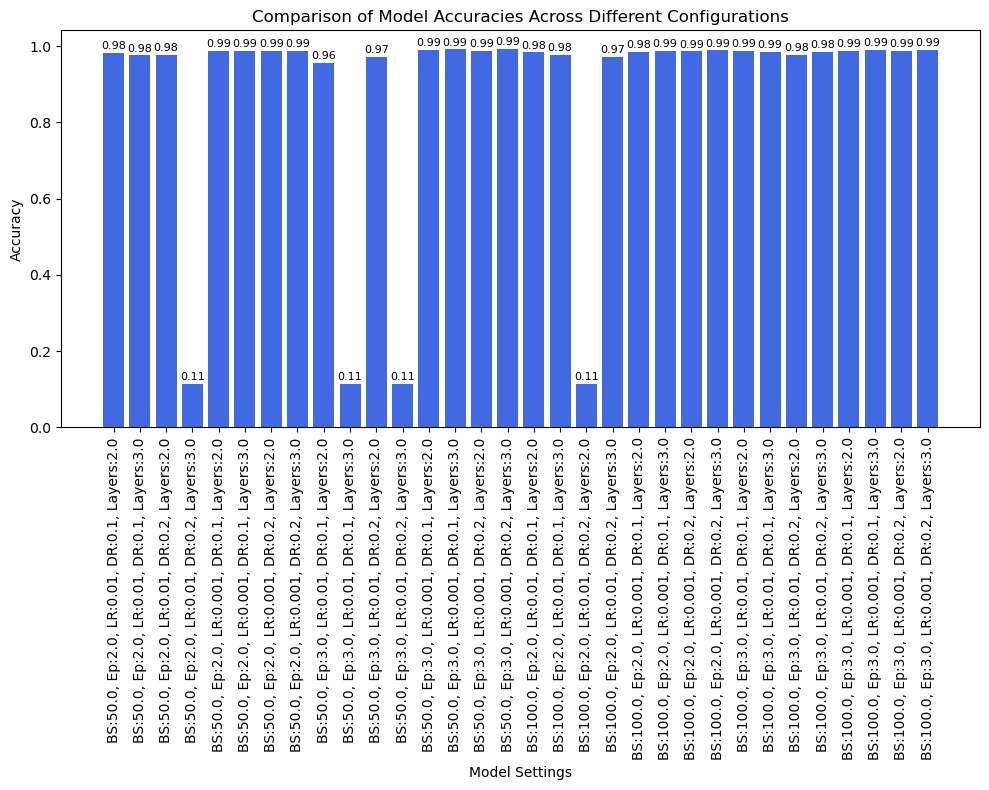

In [22]:
plot_results(results)

## CNN Architecture Shape Transformation

### Input
- **Shape:** `1x28x28`

### Conv1
- **Operation:** Convolution with `16 filters`, `5x5`, `stride=1`, `padding=2`
- **Shape after Conv1:** `16x28x28`
- **Operation:** Max Pooling with `kernel size=2`, `stride=2`
- **Shape after MaxPool1:** `16x14x14`

### Conv2
- **Operation:** Convolution with `32 filters`, `5x5`, `stride=1`, `padding=2`
- **Shape after Conv2:** `32x14x14`
- **Operation:** Max Pooling with `kernel size=2`, `stride=2`
- **Shape after MaxPool2:** `32x7x7`

### Conv3
- **Operation:** Convolution with `64 filters`, `5x5`, `stride=1`, `padding=2`
- **Shape after Conv3:** `64x7x7`
- **Operation:** Max Pooling with `kernel size=2`, `stride=2`
- **Shape after MaxPool3:** `64x3x3`

### Fully Connected Layer
- **Operation:** Flatten
- **Shape before FC:** `64x3x3` (flattened to `576`)
- **Operation:** Linear transformation to `10 classes`
- **Output Shape:** `10`


In [ ]:
# w_out = (w_in - F +2p) /s + 1